<a href="https://colab.research.google.com/github/MonitSharma/Computational-Methods-in-Physics/blob/main/Lennard_Jones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Lennard-Jones Potential

### The Model Fluid

The topic of the fundamental molecular dynamics of non-bonded interactions is studied using a soft-disk fluid simulation, which is an implementation of the Equation of Motion in which a spherical particle (atoms) interact with one another. Interactions between pairs of atoms are calculated for providing the two principal features of interatomic forces:

<li>      Repulsive forces: resistance to compression.

<li> Attractive forces: mutual attraction of pairs of particles over a range of separations (dipole-dipole, dipole-induced dipole, van der Waals forces encompassing London dispersion forces).


The genral equation that calculates these features is the Lennard-Jones potential (LJP).

This potential governs the strength of the interaction and repulsion for a pair of atoms $i$ and $j$ located at $r_i$ and $r_j$ positions. It calculates their accelerations and forces based on their distance of separation $r$.

$ u(r_{ij}) = 4ϵ \bigg[ \bigg( \frac{\sigma}{r_{ij}}\bigg)^{12} - \bigg(\frac{\sigma}{r_{ij}}\bigg)^{6} \bigg]$ 



The LJP model is composed of two components: the repulsive $(σ/r)¹²$ and the attractive term $(σ/r)⁶$, which respectively denote repulsive and attractive forces. The parameter $r$ is the distance between the two atoms (in $Å$ units);

$σ$ is a length scale representing the distance at which the intermolecular potential between the two atoms is $= 0$ (in $Å$ units), and $ε$ governs the strength of the interaction (in $eV$ units). In essence, it’s a measure of how strongly two atoms attract each other.

Finally, $u$ is the intermolecular potential between the two particles. The interaction repels at close range, then attracts, and is cut off at some limiting separation $r_c$: as the parameter $r$ increases towards $r_c$, the force drops to $0$.

### The LJP Curve

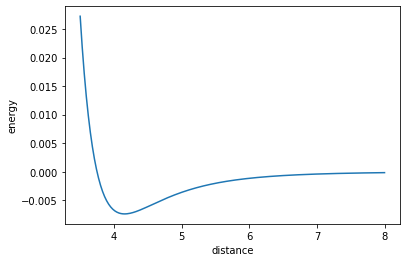

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def potential(r, epsilon, sigma):

  return 48 * epsilon * np.power(sigma, 12) / np.power(r, 13)- 24 * epsilon * np.power(sigma, 6) / np.power(r, 7)



r = np.linspace(3.5, 8, 300)
plt.plot(r,potential(r, 0.0103, 3.34))
plt.xlabel('distance')
plt.ylabel('energy')
plt.show()

For computational simplicity, Rapaport has modified the LJP in the example reported in Chapter Two, simplifying the interaction by ignoring the attractive tail represented by the van der Waals forces. Moreover, $ε$ and $σ$ are set to $1$.

The Limiting separation is:     

$ r_{ij} < r_{c} = 2^{1/6} σ$

If we construct the model fluid with this kind of potential, the simulation will look like a little more than a collection of $\textbf{colliding softballs}$

### Including Newtonian Mechanics
Considering Newton's second law of motion, where $F$ is the force for each pair of particles at a position $r$.
The Equation becomes:     

$ F_{i}(r_{ij}) = 48 ϵ \bigg[ \bigg( \frac{\sigma^{12}}{r_{ij}^{13}}\bigg) - 24 ϵ \bigg(\frac{\sigma^6}{r_{ij}^7}\bigg) \bigg]$ 


Also, Newton’s third law implies that $F_{ji}$ is equal to -$F_{ij}$, so the force on particle $i$ from the pairwise interaction $u(r_{ij})$ has the opposite direction of the force on particle $j$. The calculation of forces will need to be numerically integrated, and it will allow us to derives coordinates, velocities, and accelerations of each atom within the simulation.

## Soft-Disk Fluid Algorithm for a 2-Dimension



1. The Main coordinates the flux, firstly calling 
```SetParams```  and ```SetupJob``` that are two functions for the program initialization. ```SetParams``` serves to set many global parameters, while ```SetupJob``` embodies ```InitCoords```, ```InitVels```, and ```InitAccels```, which are functions for the initialization of the coordinates, the velocities, and the accelerations of all the atoms, respectively.


2.   Everything Main has to do will be calling ```SingleStep```, which represents the function that handles the whole process. ```SingleStep``` will call ```LeapFrogStep```, which performs the integration of Equation of Motion using a simple numerical technique: the leapfrog method. This method has excellent energy conservation properties, integrating the coordinates and velocities of the particles. The LeapFrogStep appears twice in the listing of ```SingleStep```, with the argument 1 or 2 that determines which portion of the two-step leapfrog process is to be performed. Finally, ```SingleStep``` encompasses ```ComputeForces```, which implements the LJP and the forces and updates atom accelerations, and two functions for the properties measurements: ```EvalProps``` and ```AccumProps```   




In [2]:
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from PIL import Image
import glob
import moviepy.editor as mp
from datetime import datetime
import time

Introducing one Python class for the molecule definition (class Mol) and one for the properties (class Prop).

In [3]:
class Mol():
    def __init__(self, r, rv, ra):
        self.r = np.asarray([0.0, 0.0]) 
        self.rv = np.asarray([0.0, 0.0])
        self.ra = np.asarray([0.0, 0.0])
        
        
class Prop():
    def __init__(self, val, sum1, sum2 ):
        self.val=val
        self.sum1=sum1
        self.sum2=sum2   

Replacing all the functions for the vector operations with linear algebra functions from NumPy. Also, written all the necessary functions for the randomness and for updating the coordinates in periodic boundaries

In [4]:
# BASIC FUNCTIONS

# Sqr and Cube functions:

def Sqr(x):
    return (x * x) 

def Cube(x):
    return ((x) * (x) * (x))

  
# Randomness functions: 

def RandR():
    global randSeedP
    randSeedP = (randSeedP * IMUL + IADD) & MASK
    return (randSeedP * SCALE)

def VRand(p):
    s: float
    s = 2. * math.pi * RandR()
    p[0] = math.cos(s)
    p[1] = math.sin(s)
    return p


# Toroidal functions:
def VWrapAll(v):
    if v[0] >= 0.5 * region[0]:
        v[0] -= region[0]
    elif v[0] < -0.5 * region[0]:
        v[0] += region[0]
        
    if v[1] >= 0.5 * region[1]:
        v[1] -= region[1]
    elif v[1] < -0.5 * region[1]:
        v[1] += region[1]        
        
    
# This function updates coordinates taking care of periodic boundaries    
def ApplyBoundaryCond():
    for n in range(nMol):
        VWrapAll(mol[n].r)

The initialization functions for coordinates, velocities, and accelerations, are included in the following code

In [5]:
# INITIALIZE COORDINATES.
# Here a simple square lattice (with the option of unequal edge lenghts) is used,
# so that each cell contains just one atom and the system is centered about the origin
def InitCoords():

    c = np.asarray([0.0, 0.0]) # Coords
    gap = np.divide(region, initUcell)
    n = 0
    for ny in range(0, int(initUcell[1])):
        for nx in range(0, int(initUcell[0])):
            
            #c = np.asarray([nx+0.5, ny+0.5])
            #c = np.multiply(c, gap)
            #c = np.add(c, np.multiply(-0.5, region))
            #mol[n].r = c   
            
            mol[n].r = np.add(np.multiply(np.asarray([nx+0.5, ny+0.5]), gap), np.multiply(-0.5, region)) 
            n = n+1
            
            
# INITIALIZE VELOCITIES.
# The initial velocities are set to fixed magnitude (velMag)
# that depends on the temperature. After assigning random velocity directions
# the velocoties are adjusted to ensure that the center of mass is stationary.
# The function vRand serves as a source of uniformly distribuited radnom unit vectors.
def InitVels():
    
    global vSum
    vSum = np.zeros(vSum.shape)    
    
    for n in range(nMol):
        VRand(mol[n].rv)
        mol[n].rv = np.multiply(mol[n].rv, velMag)                
        vSum = np.add(vSum, mol[n].rv)


    for n in range(nMol):
        mol[n].rv = np.add(mol[n].rv, np.multiply((- 1.0 / nMol),  vSum))
        
        
# INITIALIZE ACCELERATIONS.
# The accelerations are initilized to zero
def InitAccels():
    for n in range(nMol):
        mol[n].ra = np.zeros(mol[n].ra.shape)

The two functions ```SetParams``` and ```SetupJob``` are presented

In [6]:
# Set parameters
def SetParams():

    global rCut
    global region
    global velMag # velocity magnitude
    
    rCut = math.pow(2., 1./6. * sigma)
    # Define the region
    region = np.multiply( 1./math.sqrt(density), initUcell)    
    nMol = len(mol) 
    #velocity magnitude depends on the temperature
    velMag = math.sqrt(NDIM * (1. -1. /nMol) * temperature)

        
# Setup Job
def SetupJob():
    
    global stepCount #  timestep counter 

    stepCount = 0 
    InitCoords()
    InitVels()
    InitAccels()
    AccumProps(0)

Introducing the attractive tail represented by the van der Waals forces

In [7]:
# FORCES COMPUTATION
'''
ComputeForces
ComputeForces is responsible for the interaction computations, and the interactions occur between pairs of atoms. 
The function implements the LJP, and calculates the accelerations and the forces for each pairs of atoms i and j 
located at ri and rj.
rCut = Limiting separation cutoff (rc), and it is: rCut = math.pow(2., 1./6.)
As r increases towards rCut, the force drops to 0.
Newton's third law inplies that fji = -fij, so each atom pair need only be examined once.
The amount of work is proportional to N^2.
'''

def ComputeForces():
    
    global virSum
    global uSum 
    fcVal = 0 #  The force that atom j exerts on atom i
 
    # rCut: Rc
    rrCut = Sqr(rCut)
    for n in range(nMol):
        mol[n].ra = np.zeros(mol[n].ra.shape)
    uSum = 0.
    virSum = 0.

    n = 0
    for j1 in range(nMol-1):
        for j2 in range(j1+1, nMol):
            
            # Make DeltaRij: (sum of squared RJ1-RJ2)
            dr = np.subtract(mol[j1].r, mol[j2].r) # dr contains the delta between Rj1 and Rj2
            VWrapAll(dr) # toroidal function
            rr= (dr[0] * dr[0] + dr[1] * dr[1]) # dr2
            r= np.sqrt(rr) #dr
            
            # if dr2 < Rc^2 
            if (rr < rrCut):
                rri = sigma / rr                
                rri3 = Cube(rri)
                
                # Forces calculation by Lennard-Jones potential (original from Rapaport)
                # fcVal = 48. * rri3 * (rri3 - 0.5) * rri
                # Forces calculated with the completed Lennard-Jones.
                fcVal = 48 * epsilon * np.power(sigma, 12) / np.power(r, 13) - 24 * epsilon * np.power(sigma, 6) / np.power(r, 7) 

                # Update the accelerations multiplying force for DeltaRij
                mol[j1].ra = np.add(mol[j1].ra, np.multiply(fcVal, dr))
                mol[j2].ra = np.add(mol[j2].ra, np.multiply(-fcVal, dr))
                
                # Lennard-Jones potential (original from Rapaport)
                # uSum += 4. * rri3 * (rri3 - 1.) +1. 
                # The completed Lennard-Jones.
                uSum += 4 * epsilon * np.power(sigma/r, 12)/r - np.power(sigma/r, 6) # balanced              



                virSum += fcVal * rr

 Below code includes the leapfrog method for the Integration of the Equation of Motion

In [8]:
# INTEGRATION
'''
INTEGRATION OF COORDINATES AND VELOCITIES.
Integration of Equation of Motion uses a simple numerical techniques: the leapfrog method.
The method has excellent energy conservation properties.
LeapfrogStep integrates the coordinates and velocities. It appears twice in the listing of
SingleStep, with the argument part determinating which portion of the two-step leapfrog process
is to be performed:
vix(t + h/2) = vix(t) + (h/2)aix(t)
rix(t + h) = rix(t) + hvix (t + h/2)
'''
def LeapfrogStep(part):
    
    if part == 1:
        for n in range(nMol):
            mol[n].rv = np.add(mol[n].rv, np.multiply(0.5 * deltaT, mol[n].ra))            
            mol[n].r = np.add(mol[n].r, np.multiply(deltaT, mol[n].rv))                        
            
    else :
        for n in range(nMol):
            mol[n].rv = np.add(mol[n].rv, np.multiply(0.5 * deltaT, mol[n].ra))   

Below code provides all the functions for the properties measurements (Temperature, Energy, and Pressure).

In [9]:
# PROPERTIES MEASUREMENTS

def EvalProps():
    
    global vSum
    vvSum = 0.
    vSum = np.zeros(vSum.shape)
    
    global kinEnergy
    global totEnergy
    global pressure
    
    
    for n in range(nMol):
        vSum=np.add(vSum, mol[n].rv)
        vv= (mol[n].rv[0] * mol[n].rv[0] + mol[n].rv[1] * mol[n].rv[1])
        vvSum += vv
        
    kinEnergy.val = (0.5 * vvSum) / nMol
    totEnergy.val = kinEnergy.val + (uSum / nMol)
    pressure.val = density * (vvSum + virSum) / (nMol * NDIM)
    
    
    
# AccumProps functions

def PropZero(v):
    v.sum1 = v.sum2 = 0.
    return v    
    
def PropAccum(v):
    v.sum1 += v.val
    v.sum2 += Sqr(v.val)
    return v    
    
def PropAvg(v, n):
    v.sum1 /= n
    v.sum2 = math.sqrt(max(v.sum2 / n - Sqr(v.sum1), 0.)) 
    return v    
    

# AccumProps: collects results of the measurements and evaluates means and standard deviation
def AccumProps(icode):
    
    
    if icode == 0:
        PropZero(totEnergy)
        PropZero(kinEnergy)
        PropZero(pressure) 
    if icode == 1:
        PropAccum(totEnergy)
        PropAccum(kinEnergy)
        PropAccum(pressure)    
    if icode == 2:
        PropAvg(totEnergy, stepAvg)
        PropAvg(kinEnergy, stepAvg)
        PropAvg(pressure, stepAvg) 

Function for plotting the trajectories of the atoms (plotMolCoo), which makes all the plots step by step, and a second function that creates an mp4 video from all the coordinates plot tiles. The two functions have to work together. Also,including GraphOutput, a function for printing properties in a pandas dataframe shape.

In [10]:
# OUTPUT FUNCTIONS:

def plotMolCoo(mol, workdir, n):
    
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt

    Time = timeNow
    Sigma_v = "{0:.4f}".format(vSum[0] / nMol)
    E = "{0:.4f}".format(totEnergy.sum1)
    Sigma_E = "{0:.4f}".format(totEnergy.sum2)
    Ek = "{0:.4f}".format(kinEnergy.sum1)
    Sigma_Ek = "{0:.4f}".format(kinEnergy.sum2)
    P_1 = "{0:.4f}".format(pressure.sum1)
    P_2 = "{0:.4f}".format(pressure.sum2)    
    
    
    %matplotlib inline
    
    TileName = (workdir+'coo/'+str(n)+'.png')

    x = []
    y = []
    
    for n in range(len(mol)):
        x.append(mol[n].r[0])
        y.append(mol[n].r[1])
        
    mark_1 = int(len(mol)/2 + len(mol)/8)
    mark_2 = int(len(mol)/2 + len(mol)/8 + 1)
    
    plt.plot(x, y, 'o', color='black')
    plt.plot(x[mark_1], y[mark_1], 'o', color='red')
    plt.plot(x[mark_2], y[mark_2], 'o', color='yellow')  
    

    plt.title('timestep:'+"{0:.4f}".format(timeNow)+'; '+\
              '$\Sigma v$:'+Sigma_v+'; '+\
              'E:'+E+'; '+\
              '$\sigma E$:'+Sigma_E+';\n'+\
              'Ek:'+Ek+'; ' +\
              '$\sigma Ek$:'+Sigma_Ek+'; '+\
              'P.sum1:'+P_1+'; '+\
              'P.sum2:'+P_2+'; ', loc='left')
    
    #plt.rcParams["figure.figsize"] = (200,3)
    plt.savefig(TileName, dpi=100)
    
    
def makeMov():
    # For more information about the use of the glob package with Python, and for the convertion from 
    # gif to mp4 video formats visit the documentation   
    
    
    t = time.localtime()
    current_time = time.strftime("%D:%H:%M:%S", t)
    current_time = current_time.replace('/','-')


    # Create the frames
    frames = []
    imgs = sorted(glob.glob('coo/*.png'), key=os.path.getmtime)
    for i in imgs:
        temp = Image.open(i)
        keep = temp.copy()
        frames.append(keep)
        temp.close()
    for i in imgs:
        os.remove(i)        

    # Save into a GIF file that loops forever
    frames[0].save('coo/coordinates.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=30, loop=0)


    clip = mp.VideoFileClip("coo/coordinates.gif")
    clip.write_videofile("coo/"+"coordinates_"+current_time+".mp4")
    os.remove("coo/coordinates.gif")



def PrintSummary():

    print(stepCount, \
          "{0:.4f}".format(timeNow), \
          "{0:.4f}".format(vSum[0] / nMol) ,\
          "{0:.4f}".format(totEnergy.sum1),\
          "{0:.4f}".format(totEnergy.sum2), \
          "{0:.4f}".format(kinEnergy.sum1), \
          "{0:.4f}".format(kinEnergy.sum2),\
          "{0:.4f}".format(pressure.sum1),\
          "{0:.4f}".format(pressure.sum2))
    
    return (stepCount, \
          timeNow, \
          (vSum[0] / nMol) ,\
          totEnergy.sum1,\
          totEnergy.sum2, \
          kinEnergy.sum1, \
          kinEnergy.sum2,\
          pressure.sum1,\
          pressure.sum2)    


def GraphOutput():

    ax = \
    df_systemParams.plot(x="timestep", y='$\Sigma v$', kind="line")
    df_systemParams.plot(x="timestep", y='E', kind="line", ax=ax, color="C1")
    df_systemParams.plot(x="timestep", y='$\sigma E$', kind="line", ax=ax, color="C2")
    df_systemParams.plot(x="timestep",  y='Ek', kind="line", ax=ax, color="C3")
    df_systemParams.plot(x="timestep", y='$\sigma Ek$', kind="line", ax=ax, color="C4")
    df_systemParams.plot(x="timestep", y='P_1', kind="line", ax=ax, color="C9")
    df_systemParams.plot(x="timestep", y='P_2', kind="line", ax=ax, color="C9")

    plt.show()
    #plt.savefig('plot.jpg', dpi=300)

Here, the SingleStep function: the real gear of the whole algorithm.

In [11]:
# HANDLING FUNCTION (SingleStep())
'''
SingleStep: Is the function that handles the processing for a single timestep, including: 
1) the force evaluation
2) integration of the equation of motion, 
3) adjustments required by periodic boundaries, and
4) property measurements
'''
def SingleStep():
    
    global stepCount #  timestep counter
    global timeNow    

    stepCount +=1
    timeNow = stepCount * deltaT
    LeapfrogStep(1)
    ApplyBoundaryCond()
    ComputeForces() # 1) The force evaluation
    LeapfrogStep(2) # 2) Integration of coordinates and velocities
    EvalProps()
    AccumProps(1) # Accumulate properties

    if (stepCount % stepAvg == 0):
        AccumProps(2) # Calculate averages
        systemParams.append(PrintSummary())
        AccumProps(0) # Set to zero all the properties.

And the Main Loop

100 0.5800 0.0000 3.4273 0.0984 0.7558 0.1015 9.0259 0.7083
200 1.1600 -0.0000 3.3557 0.0257 0.7849 0.0150 8.6759 0.1304
300 1.7400 -0.0000 3.3084 0.0219 0.8068 0.0168 8.4562 0.1252
400 2.3200 -0.0000 3.3087 0.0142 0.8046 0.0137 8.4627 0.0940
500 2.9000 -0.0000 3.2974 0.0219 0.8172 0.0162 8.3811 0.1241
600 3.4800 -0.0000 3.2912 0.0178 0.8103 0.0174 8.3927 0.1222
700 4.0600 -0.0000 3.3133 0.0128 0.8094 0.0144 8.4617 0.0933
800 4.6400 -0.0000 3.2776 0.0150 0.8164 0.0165 8.3338 0.1025
900 5.2200 -0.0000 3.2810 0.0191 0.8244 0.0154 8.2994 0.1155
1000 5.8000 -0.0000 3.3174 0.0140 0.7995 0.0123 8.5067 0.0822
1100 6.3800 -0.0000 3.2717 0.0197 0.8221 0.0102 8.2881 0.0857
1200 6.9600 -0.0000 3.2613 0.0163 0.8215 0.0168 8.2647 0.1118
1300 7.5400 -0.0000 3.2632 0.0130 0.8272 0.0132 8.2355 0.0823
1400 8.1200 -0.0000 3.2800 0.0127 0.8187 0.0121 8.3133 0.0730
1500 8.7000 -0.0000 3.2702 0.0228 0.8267 0.0227 8.2666 0.1508
1600 9.2800 -0.0000 3.2783 0.0203 0.8222 0.0161 8.2975 0.1230
1700 9.8600 -0.000

100%|██████████| 2000/2000 [00:33<00:00, 59.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: coo/coordinates_11-18-21:19:07:46.mp4 



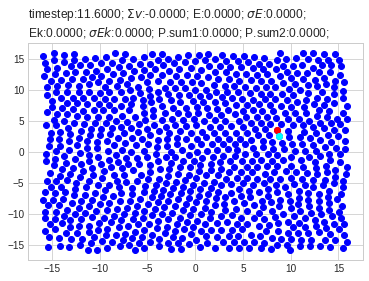

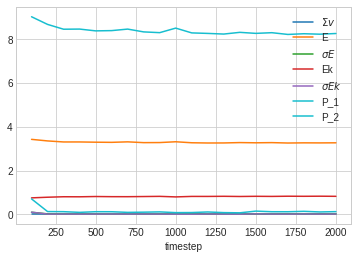

In [12]:
# 2D SOFT-DISK SIMULATION: THE MAIN LOOP

# Import libraries for system operations
import os.path
from os import path
import shutil

# PARAMETERS
mov = 1 # set mov=1 if you want make a video

# Set a working directory for all the png and videos
workdir = str(os.getcwd()+'/')

# If the /coo directory doesn't exist make it, else remove /coo (and its contents) and 
# create a new /coo directory.
if path.exists(str(workdir+'coo'))==False:
    os.makedirs(str(workdir+'coo'))
else:
    shutil.rmtree(str(workdir+'coo'))
    os.makedirs(str(workdir+'coo'))

# Load the input parameter file
df_params = pd.read_csv('Rap_3_LJP1.in', sep='\t', header=None, names=['parameter', 'value'])

NDIM = 2 # Two-Dimension setting
vSum = np.asarray([0.0, 0.0]) # velocity sum
kinEnergy =Prop(0.0, 0.0, 0.0) #Ek (and average)
totEnergy =Prop(0.0, 0.0, 0.0) #E (and average)
pressure  =Prop(0.0, 0.0, 0.0) #P (and average) 

systemParams = []

IADD = 453806245
IMUL = 314159269
MASK = 2147483647
SCALE = 0.4656612873e-9
randSeedP = 17

deltaT = float(df_params.values[0][1])
density = float(df_params.values[1][1])

initUcell = np.asarray([0.0, 0.0]) # initialize cell
initUcell[0] = int(df_params.values[2][1])
initUcell[1] = int(df_params.values[3][1])

stepAvg = int(df_params.values[4][1])
stepEquil = float(df_params.values[5][1])
stepLimit = float(df_params.values[6][1])
temperature = float(df_params.values[7][1])
float(df_params.values[7][1])

#Define an array of Mol
mol = [Mol(np.asarray([0.0, 0.0]), \
           np.asarray([0.0, 0.0]), \
           np.asarray([0.0, 0.0])) for i in range(int(initUcell[0]*initUcell[1]))]


# Define the number of molecules
global nMol
nMol = len(mol)

# LJP parameters:
epsilon =  1
sigma = 1


# START THE MAIN LOOP
SetParams()
SetupJob()
moreCycles = 1

n = 0
while moreCycles:
    SingleStep()
    if mov==1:
        plotMolCoo(mol, workdir, n) # Make a graph of the coordinates
    n += 1
    if stepCount >= stepLimit:
        moreCycles = 0
        

columns = ['timestep','timeNow', '$\Sigma v$', 'E', '$\sigma E$', 'Ek', '$\sigma Ek$', 'P_1', 'P_2']
df_systemParams = pd.DataFrame(systemParams, columns=columns)        

# Make a video
if mov==1:
    makeMov()

GraphOutput()

A Soft-Disk fluid simulation based on the Lennard-Jones Potential represents a microscopic model of a fluid or gas. It is based on spherical particles simulating atoms that interact among them. The interactions occur between pairs of particles exploiting repulsive and attractive forces. As seen in the video, after 500 timesteps, the two colored atoms, which initially were close, tend to move in different directions.